# Rap music lyrics analysis
## Contents
- [Word frequencies](#How-often-does-each-artist-mention-a-given-term?)
- [Word usage correlations](#Word-usage-correlations)
- [Values over time](#Measure-values-over-time)
- [NLTK](#NLTK)
- [scikit-learn](#scikit-learn)
- [Word clouds](#Word-clouds)
- [Dimensionality reduction](#Dimensionality-reduction)

---

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image, display
import nltk
from nltk.classify import apply_features
from nltk import word_tokenize
from collections import Counter
import random
import time
import re
from datetime import datetime
fs = 16 # fontsize

## Scrape artists and lyrics
Use the ```downloadLyrics.py``` file for this

## Load and format the lyrics JSON object

In [4]:
artists_rap = json.load(open('lyrics/rap_lyrics.json'))

In [8]:
artists_rock = json.load(open('lyrics/rock_lyrics.json'))

In [9]:
artists_country = json.load(open('lyrics/country_lyrics.json'))

In [5]:
# artists_raw = artists_rap + artists_rock + artists_country
artists_raw = artists_rap

In [6]:
# Determine
def getArtistImage(songs):    
    urls = [None]
    for song in songs:
        if song['raw']['album'] is not None:
            try:                
                urls.append(song['raw']['album']['artist']['image_url'])                
            except:
                pass
    
    return Counter(urls).most_common()[0][0] # Most common image

# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 10, 2500
artists = list(filterBySongCount(artists_raw, min_songs, max_songs))

# Artist images
for artist in artists:
    artist['image_url'] = getArtistImage(artist['songs'])
    
    # Kludge
    if artist['artist'] == 'Black Thought':
        artist['image_url'] = 'https://images.genius.com/23de511f4ac50d900128ea363b7d81b3.450x320x1.jpg'
    if artist['artist'] == 'André 3000':
        artist['image_url'] = 'http://images.genius.com/64b15c9489c65f5bf8f6577334347404.434x434x1.jpg'            
        
# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs, genres = [], []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        if len(song['lyrics'].split(' ')) > 10:
            all_songs.append(song)
            if song['genre'] not in genres:
                genres.append(song['genre'])
              
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 132 artists, with a minimum of 10 songs per artist.
Female: 41, male: 91
Database contains 24754 songs.


In [7]:
for artist in artists[:3]:
    print(artist['artist'])
    display(Image(url=artist['image_url'], width=100))

2Pac


Eminem


The Notorious B.I.G.


In [105]:
beatles = [artist for artist in artists if artist['artist'] == 'Eminem'][0]
print(len(beatles['songs']))

506


In [106]:
regex = re.compile(r"(tracklist)|(album art(work)?)|(liner notes)|(booklet)|(credits)", re.IGNORECASE)
fake_songs = [song for song in beatles['songs'] if regex.search(song['title'])] 
print(len(fake_songs))

18


---
# Textual analysis
### [⇧](#Rap-music-lyrics-analysis)

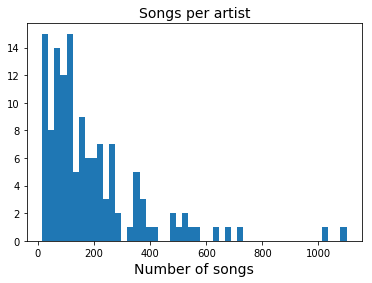

In [8]:
# How many songs do we typically have for each artist?
songs_per_artist = np.array([len(a['songs']) for a in artists])
plt.hist(songs_per_artist,50)
plt.xlabel("Number of songs", fontsize=14)
plt.title("Songs per artist", fontsize=14)
plt.show()

### Words per song

In [2]:
from string import punctuation

In [40]:
def clean_str(s):
    try:
        return "".join(c for c in s if c not in punctuation)
    except:
        return s
    
def clean_list(list_of_words):
    return [clean_str(s) for s in list_of_words]

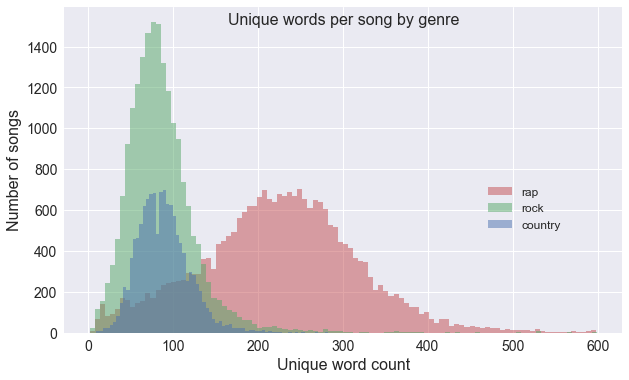

In [44]:
save = False
norm = False
unique = True
colors = ['r','g','b']
fig, ax = plt.subplots(figsize=(10,6))
for g, c in zip(genres, colors):
    # Words per song
    if unique:
        word_counts = [len(set(clean_str(song['lyrics']).split(' '))) for song in all_songs if song['genre'] == g]
        m = 600
    else:
        word_counts = [len(clean_str(song['lyrics']).split(' ')) for song in all_songs if song['genre'] == g]        
        m = 1100
    word_counts = list(filter(lambda x: x<m, word_counts))
    ax.hist(word_counts, 100, color=c, alpha=0.5, label=g, normed=norm)

# Touch up the plot
FS = 16
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if unique:
    ax.set_xlabel("Unique word count", fontsize=FS)
    title = "Unique words per song by genre"
else:
    ax.set_xlabel("Word count", fontsize=FS)    
    title = "Words per song by genre"        
if norm:
    ax.set_ylabel("Normalized frequency", fontsize=FS)
    ax.get_yaxis().set_ticks([])
    ax.spines['left'].set_visible(False)
else:    
    ax.set_ylabel("Number of songs", fontsize=FS)    
ax.text(0.5, 0.96, title, fontsize=FS,
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
ax.legend(loc=(0.75,0.3), edgecolor='k', fontsize=FS-4)
if save:
    filename = "Histogram_WordsPerSongByGenre"
    if norm:
        filename += "_normalized"
    if unique:
        filename += "_unique"
    plt.savefig(filename + ".png", format='png', dpi=300, bbox_inches='tight')
    print(filename)
else:
    plt.show()

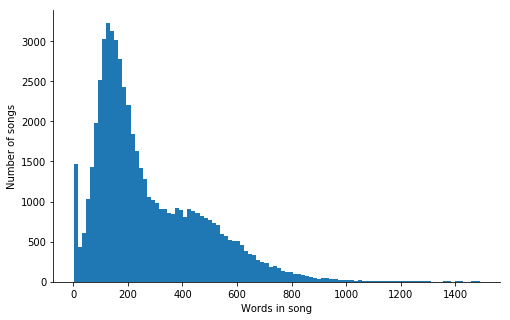

In [10]:
# Words per song
word_counts = [len(song['lyrics'].split(' ')) for song in all_songs]
word_counts = list(filter(lambda x: x<1500, word_counts))

fig, axs = plt.subplots(figsize=(8,5))
axs.hist(word_counts, 100)
axs.set_xlabel("Words in song")
axs.set_ylabel("Number of songs")
# Hide the right and top spines
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
plt.show()

## How often does each artist mention a given term?
### [⇧](#Rap-music-lyrics-analysis)

In [9]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqOfTerm(artist, terms):    
    # Determine how many songs mention a given term
    songs = artist['songs']
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[artist['artist']])

def calcTermFreqAcrossArtists(artists, terms):
    if not isinstance(terms, list):
        terms = [terms]

    term_freqs = pd.concat([calcFreqOfTerm(artist, terms) for artist in artists],axis=0)
    term_freqs.term = "_OR_".join(terms)
    return term_freqs

#### Bar graphs for term frequency

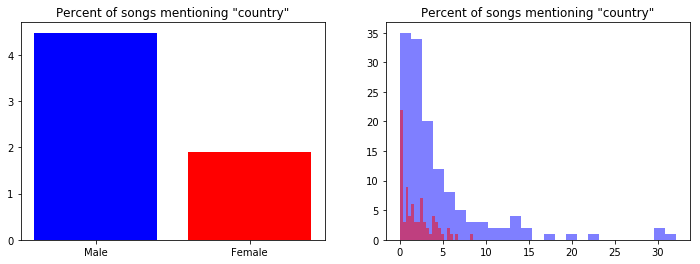

In [10]:
# Get the frequency (mentions/total songs) of a given term for each artist
freqs = calcTermFreqAcrossArtists(artists, 'country')
freqs_male   = 100*freqs['frequency'].values[mask_male]
freqs_female = 100*freqs['frequency'].values[mask_female]

# Bar graph
fig, axs = plt.subplots(ncols=2,figsize=(12,4))
axs[0].bar(0,freqs_male.mean(),color='b')#,yerr=freqs_male.std())
axs[0].bar(1,freqs_female.mean(),color='r')#,yerr=freqs_female.std())
axs[0].set_title("Percent of songs mentioning \"{}\"".format(freqs.term))
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(("Male","Female"))

# Histogram
axs[1].hist(freqs_male,25,color='b',alpha=0.5)
axs[1].hist(freqs_female,25,color='r',alpha=0.5)
axs[1].set_title("Percent of songs mentioning \"{}\"".format(freqs.term))
plt.show()

#### Bar graphs for multiple terms

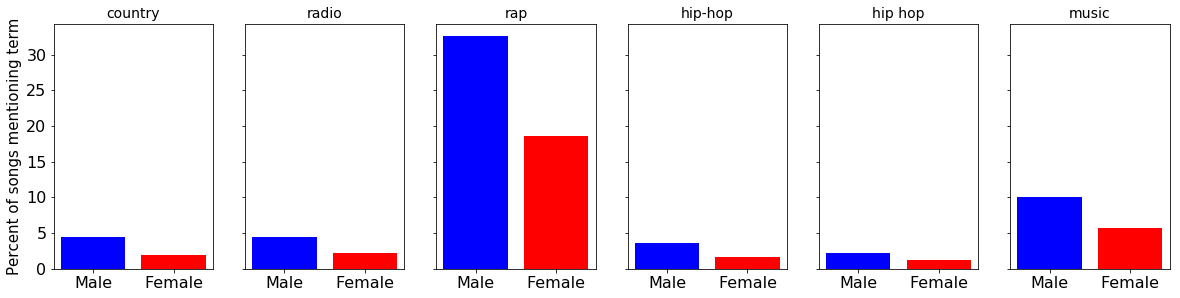

In [11]:
# terms = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Tonight']
terms = ['country','radio','rap','hip-hop','hip hop','music']
# terms = most_common[:10]
# terms = most_common[10:20]
fig, axs = plt.subplots(ncols=len(terms), sharey=True, figsize=(20,4.5))
fs = 16
for term, ax in zip(terms,axs):
    # Get the frequency (mentions/total songs) of a given term for each artist
    freqs = calcTermFreqAcrossArtists(artists, term)
    freqs_male   = 100*freqs['frequency'].values[mask_male]
    freqs_female = 100*freqs['frequency'].values[mask_female]

    # Bar graph    
    ax.bar(0, freqs_male.mean(),color='b')
    ax.bar(1, freqs_female.mean(),color='r')
    ax.set_xticks([0,1])
    ax.set_xticklabels(("Male","Female"), fontsize=fs)
    ax.set_title('{}'.format(freqs.term), fontsize=fs-2)
    ax.tick_params(labelsize=fs)
    if term == terms[0]:
        ax.set_ylabel("Percent of songs mentioning term", fontsize=fs-1)       
    
# plt.savefig('./figures/BarGraph_Weekend.png',bbox_inches='tight')
plt.show()

## Word usage correlations
### [⇧](#Rap-music-lyrics-analysis)

In [11]:
def fitLine(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    soln = np.linalg.lstsq(A, y, rcond=None)[0]    
    
    # residual sum of squares
    y_fit = soln[0]*x + soln[1]
    ss_res = np.sum((y - y_fit)**2) # residuals ?
    ss_tot = np.sum((y - y.mean())**2) # total sum of squares
    r2 = round(1 - (ss_res / ss_tot), 3) # r-squared
        
    return y_fit, x, r2

#### Interactive plot

In [11]:
import mpld3
from mpld3 import plugins
%matplotlib inline
mpld3.enable_notebook()

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: center;
}
img
{
    border-radius: 8px;
    height: auto;        
}
center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
"""

In [15]:
### Calculate two frequency variables
f1 = calcTermFreqAcrossArtists(artists, ['chopper'])
f2 = calcTermFreqAcrossArtists(artists, ['stunting'])
x, y = 100*f1['frequency'].values, 100*f2['frequency'].values

# Mask the data by gender
include_zeros = 1
if include_zeros:
    mask_not_zero = np.array([True] * len(x))
else:    
    mask_not_zero = (x > 0) * (y > 0)
mask_male   = [artist['gender']=='male'   for artist in artists] * mask_not_zero
mask_female = [artist['gender']=='female' for artist in artists] * mask_not_zero
mask_rap     = [artist['genre']=='rap'     for artist in artists] * mask_not_zero
mask_rock    = [artist['genre']=='rock'    for artist in artists] * mask_not_zero
mask_country = [artist['genre']=='country' for artist in artists] * mask_not_zero

# Create the data tips
df = pd.DataFrame({f1.term: x, f2.term: y, 'gender': labels_gender,
                   'songs': [len(a['songs']) for a in artists],
                   'genre': [a['genre'] for a in artists]})
names = [a['artist'] for a in artists]
imgs = ['<img src="{}" width="80">'.format(a['image_url']) for a in artists]
labels = []
for i in range(len(df)):
    label = df.iloc[[i], :].T    
    label.columns = [names[i]]
    html = label.drop([f1.term, f2.term], axis=0).to_html() + '\n' + imgs[i]
    labels.append(html)

# --------------------------
# Do the actual plotting
# Scatter plot the data
ms = 9
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(True, alpha=0.3)
                       
# Linear regression (really I should just do this in Seaborn)
# LR, UD = 0.05, 1.05
# for c, pos in zip(['r','b','k'],[(LR,UD),(LR,UD-0.07),(LR,UD-0.14)]):

#     # Plot the fitted lines
#     if c is 'k':
#         y_fit, t, r2 = fitLine(x[mask_not_zero], y[mask_not_zero])
#         i,j = np.argmin(t), np.argmax(t)        
#         ax.plot(t[[i,j]], y_fit[[i,j]], c)

# https://mpld3.github.io/examples/html_tooltips.html
masks_gender = [mask_female, mask_male]
masks_genre  = [mask_rap, mask_rock, mask_country]
# masks_color = ['mo','bs','ro','cs']
masks_color = ['mo','ro','y^','g^','cs','bs']
plot_labels = ['Rap (female)', 'Rap (male)', 'Rock (female)', 'Rock (male)', 'Country (female)', 'Country (male)']

count = 0
for genre in masks_genre:
    for gender in masks_gender:
        c = masks_color[count]
        mask = np.logical_and(gender, genre)
        
        if any(mask):        
            ax.plot(x[mask], y[mask], c, ms=ms, mec='k', alpha=0.5, label=plot_labels[count])
        count += 1

# ax.legend(fontsize=8, loc='lower right')

points = ax.plot(df[f1.term], df[f2.term], 'ko', mec='k', ms=ms, alpha=.01) # Plot all of the data
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

# Touch up the plot
ax.set_xlabel('Percent of an artist\'s songs mentioning "{}"'.format(f1.term),fontsize=fs)
ax.set_ylabel('% of an artist\'s songs mentioning "{}"'.format(f2.term),fontsize=fs);
ax.set_title('Mentions of "{}" and "{}" in popular rap, rock, and country music'.format(f1.term, f2.term), fontsize=fs+2)
# ax.set_aspect('equal')

mpld3.display()
# filename = '../../johnwmillr.github.io/_includes/plot_{}_{}.html'.format(f1.term,f2.term)
# mpld3.save_html(fig, filename, template_type='simple')

In [1]:
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))

NameError: name 'np' is not defined

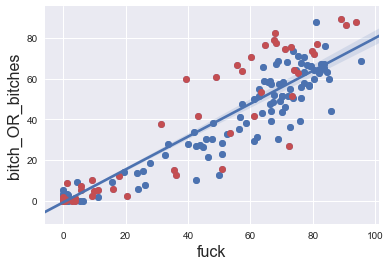

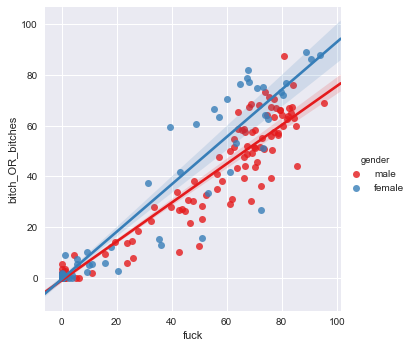

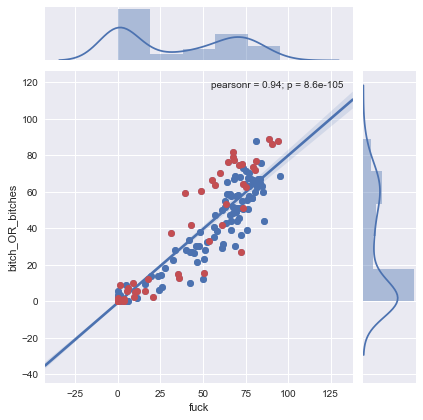

In [14]:
# Calculate two frequency variables
f1 = calcTermFreqAcrossArtists(artists, 'fuck')
f2 = calcTermFreqAcrossArtists(artists, ['bitch','bitches'])
x, y = 100*f1['frequency'].values, 100*f2['frequency'].values

# Scatter plot the data
# https://seaborn.pydata.org/tutorial/regression.html

# Regplot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x[mask_male],   y[mask_male], 'bo')
ax.plot(x[mask_female], y[mask_female], 'ro')
sns.regplot(x=x, y=y, ax=ax)
ax.set_xlabel(f1.term, fontsize=fs)
ax.set_ylabel(f2.term, fontsize=fs)
plt.show()

# LMPlot
data = pd.DataFrame({f1.term: x, f2.term: y, 'gender': labels_gender})
sns.lmplot(x=f1.term, y=f2.term, data=data, hue='gender', palette="Set1")
# plt.ylim([20,90])
plt.show()

# Jointplot
sns.jointplot(x=f1.term, y=f2.term, data=data, kind="reg")
plt.plot(x[mask_male],   y[mask_male], 'bo')
plt.plot(x[mask_female], y[mask_female], 'ro')
plt.show()

# Ideas
Fergie is in the dataset, but I'm not sure whether she qualifies as a rapper. It'd cool if the lyrics actually support that hypothesis.

#### Notes
It really should be an automated process to find the features that best split on gender.

Pipeline:
  1. Get list of unique terms by frequency using NLTK
  2. The top 50 from that list of terms will be my feature space
  3. Find the combination of terms that maximizes distance between the two classes
  
  
#### Ideas
  - From a single song's lyrics, can I predict the artist gender?
    - Each song is labeled with a gender. So, once I have some decent features, I should be able to train a classifier. Pretty straight forward.

## Measure values over time
### [⇧](#Rap-music-lyrics-analysis)

63.0% of songs have date information, for a total of 24754 songs.


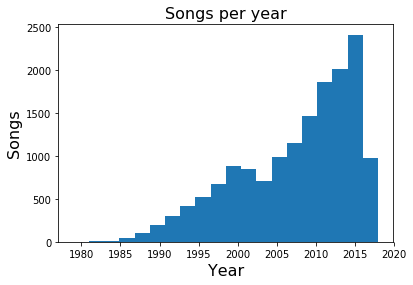

In [42]:
# TODO: make this not stupid.
songs_with_year = []
for song in filter(lambda s: s['year'] is not None, all_songs):
    d = datetime.strptime(song['year'], '%Y-%M-%d')
    if (d.year>=1900 and d.year<=2018): # kludge for correct parsing of date
#     if (d.year>=2002 and d.year<=2018): # kludge for correct parsing of date        
        song['date'] = d
        songs_with_year.append(song)
        
print("{:.1f}% of songs have date information, for a total of {} songs.".format(100*len(songs_with_year)/len(all_songs),len(all_songs)))

# Kludge to sort the songs by year
years = np.array(list(map(lambda d: d.year, [s['date'] for s in songs_with_year])))
songs_with_year = np.array([x for _, x in sorted(zip(years, songs_with_year), key=lambda pair: pair[0])])
years.sort()

# Distribution of the years
plt.hist(years, 20)
plt.xlabel("Year", fontsize=fs)
plt.ylabel("Songs", fontsize=fs)
plt.title("Songs per year",fontsize=fs)
plt.show()

### Vocabulary size and diversity

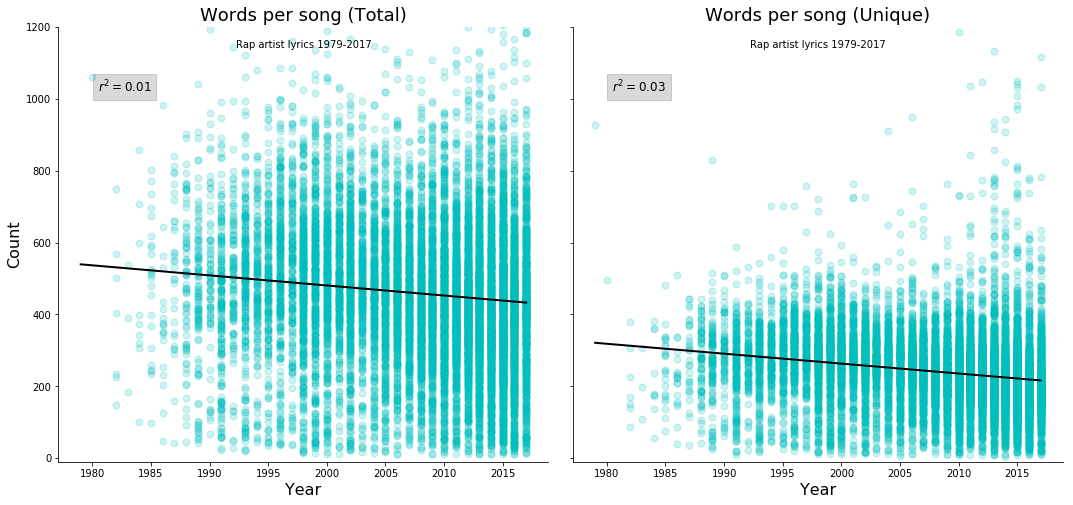

In [12]:
# http://kaylinwalker.com/50-years-of-pop-music/
# Words per song
word_counts = [len(song['lyrics'].split(' ')) for song in songs_with_year]
word_counts_unique = [len(set(song['lyrics'].split(' '))) for song in songs_with_year]

plt.figure(figsize=(18,8))
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.05)

for i, counts, title in zip(range(2),[word_counts, word_counts_unique],["Total", "Unique"]):
    ax = plt.subplot(gs1[i])
    
    y_fit, t, r2 = fitLine(years, np.array(counts))
    ax.plot(years, counts, 'co', alpha=0.2, markersize=7)
    ax.plot(t, y_fit, 'k', linewidth=2)
    ax.set_xlabel("Year", fontsize=fs)    
    ax.set_title("Words per song ({})".format(title), fontsize=fs+2)
    if i == 0:
        ax.set_ylabel("Count", fontsize=fs)
    else:
        ax.set_yticklabels([])
        
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
        bbox={'facecolor':'black', 'alpha':0.15, 'pad':5}, xycoords='axes fraction', xy=(0.08, 0.85)),        
    ax.text(0.5, 0.96, 'Rap artist lyrics {}-{}'.format(min(years),max(years)),
            transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
    ax.set_ylim([-10, 1200])
    
# plt.savefig('./figures/TimePlot_words_per_song.png', bbox_inches='tight', dpi=300)
plt.show()

In [18]:
# Lexical diversity
word_counts = [len(song['lyrics'].split(' ')) for song in songs_with_year]
word_count_ratio = [len(set(song['lyrics'].split(' ')))/float(wc) for song, wc in zip(songs_with_year, word_counts)]

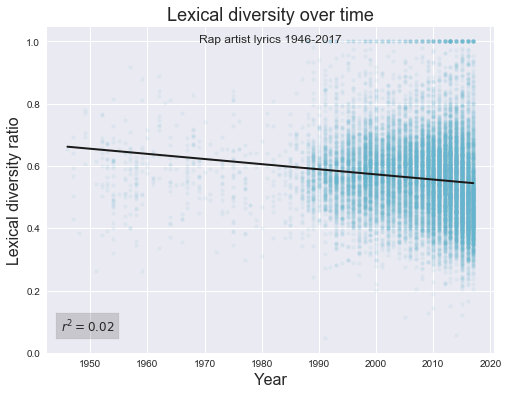

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
y_fit, t, r2 = fitLine(years, np.array(word_count_ratio))
ax.plot(years, word_count_ratio, 'co', alpha=0.1, markersize=4)
ax.plot(years, y_fit, 'k', linewidth=2)

# y_fit, t, _ = fitLine(np.array(list(ratios.keys())), averages)
# ax.errorbar(t, averages, yerr=sigs, fmt='rs')

ax.set_xlabel("Year", fontsize=fs)
ax.set_ylabel("Lexical diversity ratio", fontsize=fs)
ax.set_title("Lexical diversity over time", fontsize=fs+2)

ax.text(0.5, 0.96, 'Rap artist lyrics {}-{}'.format(min(years),max(years)),
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')

ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
    bbox={'facecolor':'black', 'alpha':0.15, 'pad':5}, xycoords='axes fraction', xy=(0.03, 0.065)),

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# fig.savefig("figures/TimePlot_lexical_diversity.png", dpi=300)
plt.show()

### Popularity of a given term over time

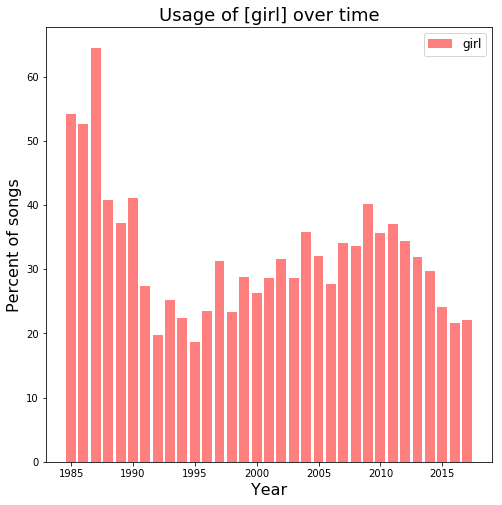

In [37]:
# terms = ['fag','faggot','gay','homo']
# terms = ['faggot']
terms = ['girl']

assert isinstance(terms, list), "terms must be of type list."
fig, axs = plt.subplots(figsize=(8,8)); colors = 'rgbcmy'; fs=16
dots = []
pos = [(0.85,0.72), (0.8,0.65), (0.65,0.9), (0.85,0.5), (0.75, 0.8)]
for i,term in enumerate(terms):

    # Store mentions of the term in a dictionary with years as the key
    mentions = {}
    songs_per_year = {}
    for song in songs_with_year:
        year = song['date'].year

        if year in songs_per_year:        
            songs_per_year[year] += 1
        else:
            songs_per_year[year] = 1

        if term in song['lyrics']:
            if year in mentions:
                mentions[year] += 1
            else:
                mentions[year] = 1

    # Normalize the mention values
    min_songs = 10
    for year in list(mentions.keys()):
        if songs_per_year[year] > min_songs:
            mentions[year] = 100*mentions[year]/float(songs_per_year[year])
        else:
            mentions.pop(year)
                
    # Linear regression
    years, counts = np.array(list(mentions.keys())), np.array(list(mentions.values()))
    counts = [x for _, x in sorted(zip(years, counts), key=lambda pair: pair[0])]
    years.sort()    
    y_fit, t, r2 = fitLine(years, np.array(counts))

    # Plot the points and the regression        
    dots.append(
#     axs.plot(years, counts, 'o', color=colors[i], markersize=9, alpha=0.5)[0])
    axs.bar(years, counts, color=colors[i], alpha=0.5)[0])    
#     axs.plot(years, y_fit,  '-', color=colors[i])      
    
#     axs.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=fs-4,
#             bbox={'facecolor':colors[i], 'alpha':0.3, 'pad':5}, xycoords='axes fraction',  xy=pos[i])
    
axs.set_title('Usage of [{}] over time'.format(', '.join(terms)),fontsize=fs+2)
axs.set_xlabel('Year',fontsize=fs)
axs.set_ylabel('Percent of songs',fontsize=fs)
axs.legend(dots,terms, fontsize=fs-4)
# plt.savefig('./figures/TimePlot_{}.png'.format("_".join(terms)),bbox_inches='tight')
plt.show()

## NLTK
### [⇧](#Rap-music-lyrics-analysis)

### Lexical diversity of all songs

In [21]:
all_word_counts = np.array([[len(song['lyrics'].split()), len(set(song['lyrics'].split()))] for song in all_songs])

In [24]:
# mask_songs_male   = np.array([song['gender'] =='male'   for song in all_songs])
# mask_songs_female = np.array([song['gender'] =='female' for song in all_songs])

mask_songs_male   = np.array([song['genre'] =='rap'   for song in all_songs])
mask_songs_female = np.array([song['genre'] =='country' for song in all_songs])

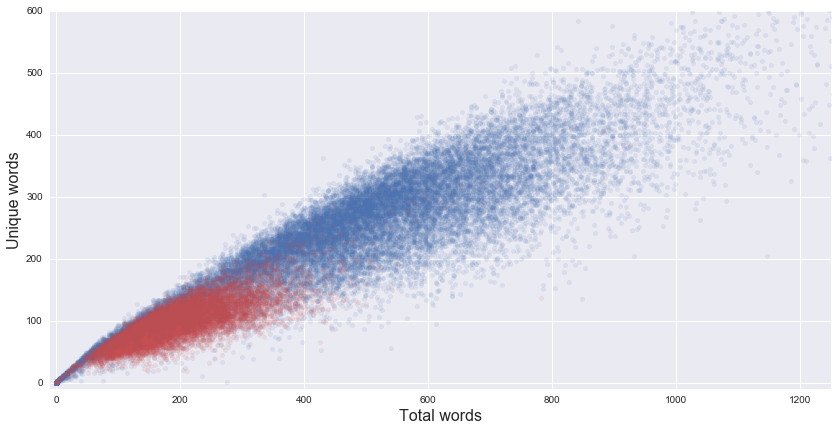

In [25]:
fig, ax = plt.subplots(figsize=(14,14))
ax.plot(all_word_counts[mask_songs_male,0],   all_word_counts[mask_songs_male,1],   'bo', alpha=0.1, markersize=5)
ax.plot(all_word_counts[mask_songs_female,0], all_word_counts[mask_songs_female,1], 'ro', alpha=0.1, markersize=5)
ax.set_aspect('equal')
ax.set_xlabel("Total words", fontsize=fs)
ax.set_ylabel("Unique words", fontsize=fs)
ax.set_xlim([-10, 1250]); ax.set_ylim([-10, 600])
plt.show()

### Lexical diversity for each artist

In [26]:
def lexdiv(lyrics):
    try:
        return len(set(lyrics.split()))/float(len(lyrics.split()))
    except:
        return 0

In [27]:
lexical_diversity = np.zeros((len(artists),1))
for i, artist in enumerate(artists):    
    lexical_diversity[i] = np.mean([lexdiv(song['lyrics']) for song in artist['songs']])
    
# Least and most lexically diverse
min_lexdiv = artists[np.argmin(lexical_diversity)]['artist']
max_lexdiv = artists[np.argmax(lexical_diversity)]['artist']
print((min_lexdiv, max_lexdiv))

In [ ]:
lexical_diversity = np.array([lexdiv(song['lyrics']) for song in all_songs])

# Least and most lexically diverse
min_lexdiv = all_songs[np.argmin(lexical_diversity)]
max_lexdiv = all_songs[np.argmax(lexical_diversity)]
print("{} by {} is the least lexically diverse song.".format(min_lexdiv['title'], min_lexdiv['artist']))
print("{} by {} is the most lexically diverse song.".format(max_lexdiv['title'], max_lexdiv['artist']))       

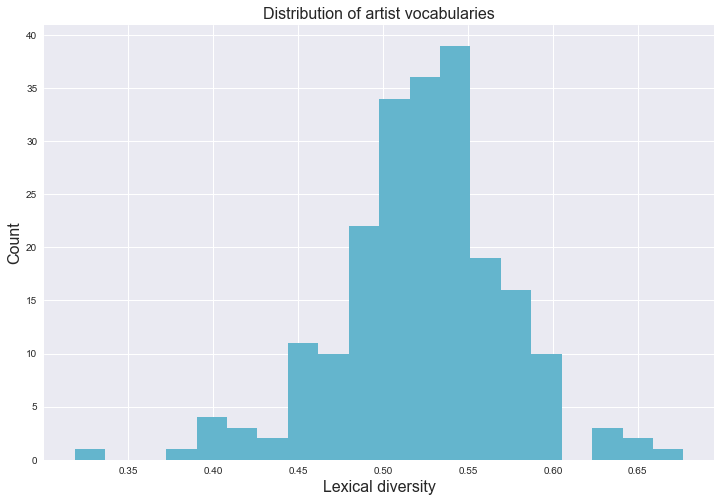

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(lexical_diversity,20,color='c')
ax.set_xlabel("Lexical diversity", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.set_title("Distribution of artist vocabularies", fontsize=fs)

ap = dict(facecolor='black', shrink=0.1, headlength=8)
# ax.annotate("",xy=(0.398,4.05), xytext=(0.397,5), arrowprops=ap)
# ax.annotate("{}".format(min_lexdiv), xy=(0.399,4.2),
#            horizontalalignment='center', fontsize=fs-4)
# ax.annotate("",xy=(0.59,2.1), xytext=(0.589,3), arrowprops=ap)            
# ax.annotate("{}".format(max_lexdiv), xy=(0.591,2.2),
#            horizontalalignment='center', fontsize=fs-4)

# ax.annotate("Less\ndiverse", xy=(0.42,8.2), xytext=(0.44,8.2), arrowprops=ap,
#             horizontalalignment='center',verticalalignment='center',fontsize=fs-4)
# ax.annotate("More\ndiverse", xy=(0.58,8.2), xytext=(0.56,8.2), arrowprops=ap,
#             horizontalalignment='center',verticalalignment='center',fontsize=fs-4)
# fig.savefig("./figures/LexDiv_distribution", bbox_inches='tight', dpi=300)
plt.show()

### Classify songs using Naive Bayes

In [154]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_songs(lyrics):
    
    def countTerm(term):        
        return lyrics.lower().count(term.lower())
    
    def isPresent(term):
        return term.lower() in lyrics.lower()    
    
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']           
    counts = [countTerm(term) for term in terms]
    
#     binary_feats = ['beer','truck','girl','baby','Friday','Saturday','Love']    
    binary_feats = []
    terms = terms + binary_feats
    counts = counts + [isPresent(term) for term in terms[-len(binary_feats):]]
    
    return dict(zip(terms, counts))


# Do this once? Or set random seed to be same each time?
labeled_songs = ([(song['lyrics'], song['gender']) for song in all_songs])
random.shuffle(labeled_songs)

# Randomly split into train and test sets
n_train = round(0.7*len(all_songs))
train_set = apply_features(gender_features_songs, labeled_songs[:n_train])
test_set  = apply_features(gender_features_songs, labeled_songs[n_train:])
classifier = nltk.NaiveBayesClassifier.train(train_set)

acc = nltk.classify.accuracy(classifier, test_set)
print(acc)
classifier.show_most_informative_features(10)

0.6425716189207196
Most Informative Features
                    beer = 3                male : female =     11.2 : 1.0
                   truck = 2                male : female =      9.8 : 1.0
                   truck = 3                male : female =      7.2 : 1.0
                    beer = 4                male : female =      6.2 : 1.0
                    beer = 1                male : female =      6.1 : 1.0
                   truck = 1                male : female =      5.4 : 1.0
                    girl = 9                male : female =      4.7 : 1.0
                  Friday = 1                male : female =      4.1 : 1.0
                    beer = 2                male : female =      4.0 : 1.0
                Saturday = 1                male : female =      3.4 : 1.0


Classifier accuracy: 0.5844330729868031


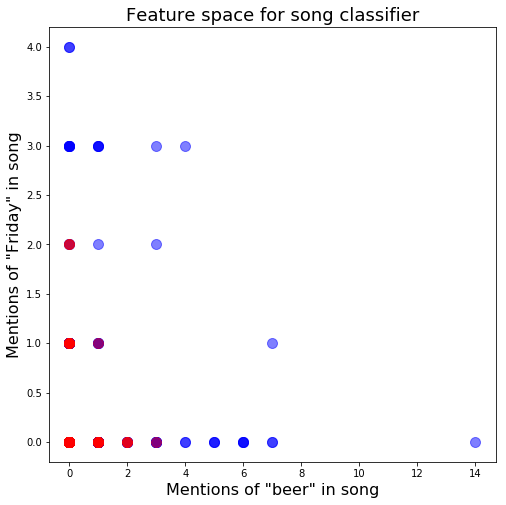

In [152]:
# View the artists in feature space
f1, f2 = 'beer','Friday'
x = np.array([sample[0][f1] for sample in test_set])
y = np.array([sample[0][f2] for sample in test_set])

mask_male   = np.array([sample[1]=='male'   for sample in test_set])
mask_female = np.array([sample[1]=='female' for sample in test_set])

print("Classifier accuracy: {}".format(acc))
fig, axs = plt.subplots(figsize=(8,8))
axs.plot(x[mask_male],   y[mask_male],   'bo', alpha=0.5, markersize=10)
axs.plot(x[mask_female], y[mask_female], 'ro', alpha=0.5, markersize=10)
axs.set_xlabel('Mentions of "{}" in song'.format(f1), fontsize=16);
axs.set_ylabel('Mentions of "{}" in song'.format(f2), fontsize=16);
axs.set_title("Feature space for song classifier", fontsize=18)
plt.show()

### Classify artists using Naive Bayes

In [155]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqForArtist(songs, terms):    
    if not isinstance(terms, list): terms = [terms]
    
    # Determine how many songs mention a given term
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[songs[0]['artist']])


In [156]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_artists(artist):                        
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']

    percents = [float(100*calcFreqForArtist(artist['songs'], term)['frequency'].values) for term in terms]       
    return dict(zip(terms, percents))

# # Do this once? Or set random seed to be same each time?
labeled_artists = ([(artist, artist['gender']) for artist in artists])
random.shuffle(labeled_artists)

# Randomly split into train and test sets
n_train = round(0.6*len(labeled_artists))
train_set = apply_features(gender_features_artists, labeled_artists[:n_train])
test_set  = apply_features(gender_features_artists, labeled_artists[n_train:])
classifier = nltk.NaiveBayesClassifier.train(train_set)

acc = nltk.classify.accuracy(classifier, test_set)
print(acc)
classifier.show_most_informative_features(20)

0.6
Most Informative Features
                   truck = 0.0            female : male   =      6.1 : 1.0
                  Friday = 0.0            female : male   =      2.9 : 1.0
                    beer = 0.0            female : male   =      2.3 : 1.0
                Saturday = 0.0            female : male   =      1.9 : 1.0
                Saturday = 0.383          female : male   =      1.1 : 1.0
                    beer = 0.565          female : male   =      1.1 : 1.0
                    girl = 13.889000000000001 female : male   =      1.1 : 1.0


Classifier accuracy: 0.6


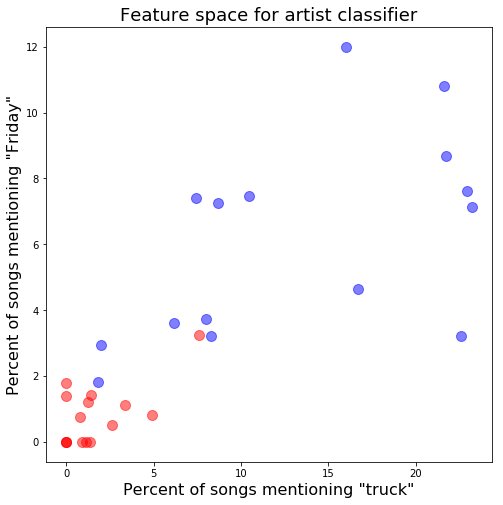

In [157]:
# View the artists in feature space
f1, f2 = 'truck','Friday'
x = np.array([sample[0][f1] for sample in test_set])
y = np.array([sample[0][f2] for sample in test_set])

mask_male   = np.array([sample[1]=='male'   for sample in test_set])
mask_female = np.array([sample[1]=='female' for sample in test_set])

print("Classifier accuracy: {}".format(acc))
fig, axs = plt.subplots(figsize=(8,8))
axs.plot(x[mask_male],   y[mask_male],   'bo', alpha=0.5, markersize=10)
axs.plot(x[mask_female], y[mask_female], 'ro', alpha=0.5, markersize=10)
axs.set_xlabel('Percent of songs mentioning "{}"'.format(f1), fontsize=16);
axs.set_ylabel('Percent of songs mentioning "{}"'.format(f2), fontsize=16);
axs.set_title("Feature space for artist classifier", fontsize=18)
plt.show()

I should try the Naive Bayes classifier from the MachineLearningInAction book
https://github.com/johnwmillr/MachineLearningInAction/blob/08626d029135aef71f3ca04661235c5438ffb100/Ch04_Bayes.ipynb

### scikit-learn
### [⇧](#Rap-music-lyrics-analysis)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
loo = LeaveOneOut()

#### Features for prediction of gender from song lyrics

In [21]:
# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_songs(lyrics):
    
    def countTerm(term):        
        return lyrics.lower().count(term.lower())
    
    def isPresent(term):
        return term.lower() in lyrics.lower()    
    
    terms = ['beer','truck','girl','baby','Friday','Saturday','Love']           
    counts = [countTerm(term) for term in terms]
    
#     binary_feats = ['beer','truck','girl','baby','Friday','Saturday','Love']    
    binary_feats = []
    terms = terms + binary_feats
    counts = counts + [isPresent(term) for term in terms[-len(binary_feats):]]
    
    return dict(zip(terms, counts))

# Do this once? Or set random seed to be same each time?
labeled_songs = ([(song['lyrics'], song['gender']) for song in all_songs])
features = apply_features(gender_features_songs, labeled_songs)
feature_names = list(features[0][0].keys())

# Extract features from song lyrics
data = np.zeros((len(features),len(features[0][0].values())))
labels = np.zeros(len(features))
for i, sample in enumerate(features):
    data[i,:] = list(sample[0].values())
    if sample[1] == 'male':
        labels[i] = 0
    else:
        labels[i] = 1
        
X, y = data, labels                    
DF = pd.DataFrame(data, columns=list(features[0][0].keys()))
DF = DF.assign(label=pd.Series(labels).values)
DF.head()

,beer,truck,girl,baby,Friday,Saturday,Love,label
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Features for prediction of gender from artist discography

In [22]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqForArtist(songs, terms):    
    if not isinstance(terms, list): terms = [terms]
    
    # Determine how many songs mention a given term
    song_count, term_count = len(songs), 0
    for song in songs:
        for term in terms:            
            if term.lower() in song['lyrics'].lower():
                term_count += 1
                break

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[songs[0]['artist']])

# Create feature space from all songs, loooking at particular terms
# labels are the song's artist's gender
def gender_features_artists(artist):                        
#     terms = ['beer','truck','girl','baby','Friday','Saturday','Love','back','want','need','get','got']
    terms = ['got','get','heart','like','love','back','little','yeah','night']

    percents = [float(100*calcFreqForArtist(artist['songs'], term)['frequency'].values) for term in terms]       
    return dict(zip(terms, percents))

labeled_artists = ([(artist, artist['gender']) for artist in artists])
artist_features = apply_features(gender_features_artists, labeled_artists)
feature_names = list(artist_features[0][0].keys())

# Extract features from artist lyrics
data = np.zeros((len(artist_features),len(artist_features[0][0].values())))
labels = np.zeros(len(artist_features))
for i, artist in enumerate(artist_features):
    data[i,:] = list(artist[0].values())
    if artist[1] == 'male':
        labels[i] = 0
    else:
        labels[i] = 1

X, y = data, labels            
DF = pd.DataFrame(data, columns=list(artist_features[0][0].keys()))
DF = DF.assign(label=pd.Series(labels).values)
DF.head()

,got,get,heart,like,love,back,little,yeah,night,label
0,76.923,80.680,38.462,73.882,57.782,59.571,28.086,35.242,36.315,0.0
1,71.542,76.087,13.834,76.087,33.794,63.834,40.514,41.304,25.099,0.0
2,83.099,84.507,17.606,84.507,54.225,65.493,30.282,42.958,24.648,0.0
3,81.233,81.769,26.810,81.233,49.866,64.611,24.397,36.729,35.925,0.0
4,84.914,89.224,7.759,82.328,39.655,61.207,34.914,50.862,23.707,0.0


### Random forest classifier for artist gender

In [23]:
# Random forest with n-fold cross validation
cv = 10
clf = RandomForestClassifier(n_estimators=50, max_features="log2")
scores = cross_validate(clf, X, y, scoring='precision_macro',cv=cv)
print("\nAverage accuracy across {} folds of CV: {:0.1f}".format(cv, 100*scores['test_score'].mean()))

# Random forest with n-fold cross validation
scores = cross_val_score(clf, X, y, cv=cv)
print("\nAverage accuracy across {} folds of CV: {:0.1f}".format(cv, 100*scores.mean()))


Average accuracy across 10 folds of CV: 71.6

Average accuracy across 10 folds of CV: 77.3


### Word clouds
### [⇧](#Rap-music-lyrics-analysis)

In [83]:
from wordcloud import WordCloud

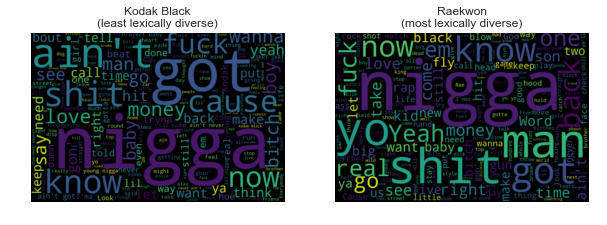

In [84]:
# Generate word clouds for the artists with the least and most lexical diversity
w,h = 1200, 800
wc_min = WordCloud(min_font_size=8,width=w,height=h).generate(" ".join([song['lyrics'] for song in artists[np.argmin(lexical_diversity)]['songs']]))
wc_max = WordCloud(min_font_size=8,width=w,height=h).generate(" ".join([song['lyrics'] for song in artists[np.argmax(lexical_diversity)]['songs']]))

artist_names = [artists[np.argmin(lexical_diversity)]['artist'] + "\n(least",
                artists[np.argmax(lexical_diversity)]['artist'] + "\n(most"]
fig, axs = plt.subplots(ncols=2, figsize=(10,10))
for ax,wc,name in zip(axs, [wc_min,wc_max], artist_names):
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("{name} lexically diverse)".format(name=name), fontsize=fs-4)

# fig.savefig("./figures/WordCloud_lexical_diversity",bbox_inches='tight',dpi=300)    
plt.show()

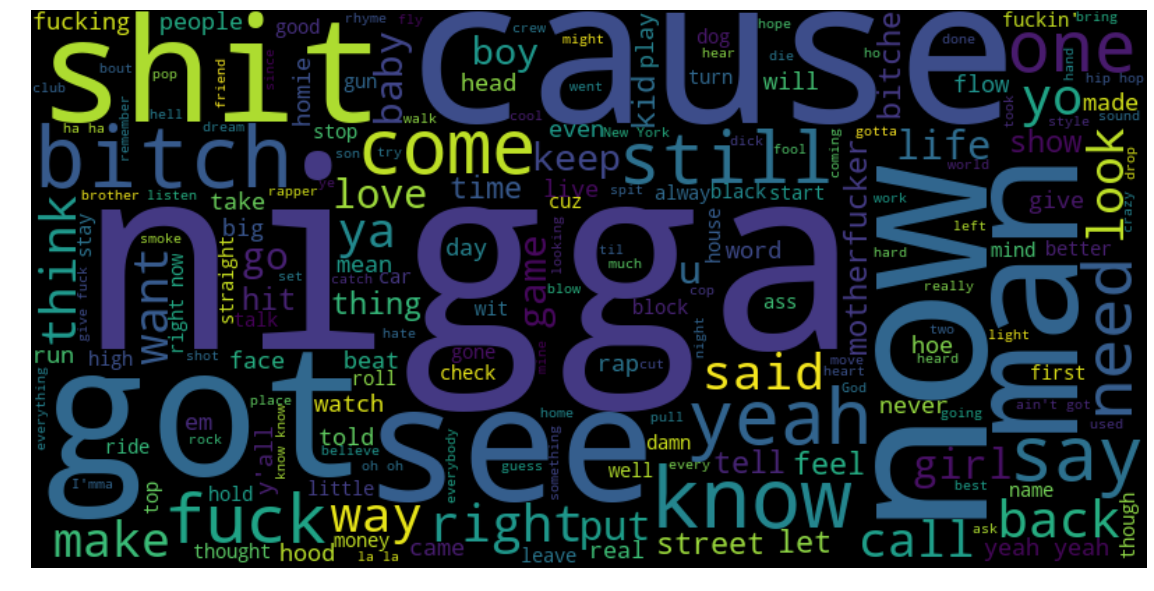

In [85]:
# Generate word clouds for all lyrics
wc1 = WordCloud(width=800,height=400).generate(all_lyrics)
plt.figure(figsize=(20,20))
plt.imshow(wc1, interpolation="bilinear")
plt.axis("off")
plt.show()

## Dimensionality-reduction
### [⇧](#Rap-music-lyrics-analysis)

In [24]:
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
from collections import Counter

### Most common words

In [25]:
start = time.time()
# Tokenize the text
tokens = word_tokenize(all_lyrics)
text = nltk.Text(tokens)

# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english') + [',']

# Frequency distribution of word usage
fdist = nltk.FreqDist(word.lower() for word in text if word.lower() not in stopwords)
end = time.time()
print("Time elapsed: {} seconds".format(end-start))

Time elapsed: 314.443656206131 seconds


In [26]:
# Try to avoid stuff like " 's " and " 'm " that have slipped through
most_common = [w[0] for w in fdist.most_common(100) if len(re.subn("[,'\.]","",w[0])[0])>2]
most_common[:10]

['like', 'got', 'get', 'know', 'love', 'nigga', 'yeah', 'see', 'one', 'back']

In [32]:
def countTermsAcrossArtist(artist, terms):
    stopwords = nltk.corpus.stopwords.words('english') + [',']
    
    artist_lyrics = " ".join([song['lyrics'] for song in artist['songs']])
    text = nltk.Text(word_tokenize(artist_lyrics.lower()))
    words = [word.lower() for word in text if word.lower() not in stopwords]
    
    # Populate the counter with zeros
    zero_counts = dict(zip(terms,[0]*len(terms)))    
    term_counts = {**zero_counts, **Counter([w for w in words if w in terms])} # merge dictionaries                
    
    # Scale by total number of words in artist's lyrics
    total_terms_counted = np.sum([val for val in term_counts.values()])
    term_counts.update((x, y/float(len(words))) for x, y in term_counts.items())
    
    return pd.Series(term_counts, name=artist['artist'])        

In [33]:
def countTermsAcrossSongs(text, terms, song_name='WordCounts'):
                
    # Clean up text before counting terms
    stopwords = nltk.corpus.stopwords.words('english') + [',']
    text = nltk.Text(word_tokenize(text.lower()))
    words = [word.lower() for word in text if word.lower() not in stopwords]
    
    # Populate the counter with zeros
    zero_counts = dict(zip(terms,[0]*len(terms)))    
    term_counts = {**zero_counts, **Counter([w for w in words if w in terms])} # merge dictionaries                
    return pd.Series(term_counts, name=song_name)

In [31]:
# Count popular word occurences either across songs or artists
# This takes about a minute to compute
start = time.time()
song_term_counts = pd.concat([countTermsAcrossSongs(song['lyrics'], most_common, song['title']) for song in all_songs],axis=1).T
term_counts = song_term_counts
# artist_term_counts = pd.concat([countTermsAcrossArtist(artist, most_common) for artist in artists], axis=1).T
# term_counts = artist_term_counts
end = time.time()
print("Time elapsed: {} seconds.".format(end-start))
term_counts.head()

KeyboardInterrupt: 

In [ ]:
print((len(most_common), song_term_counts.shape, artist_term_counts.shape))

### PCA

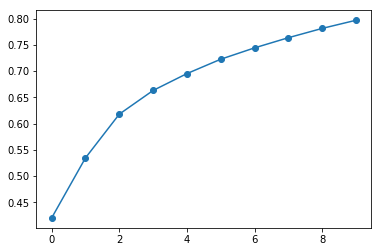

In [18]:
# Perform PCA
pca = PCA(n_components=10)
pca.fit(term_counts)

# Plot variance explained
plt.plot(pca.explained_variance_ratio_.cumsum(),'o-')
plt.show()

# Artist data in PC space
X = pca.transform(term_counts)
# X_songs = pca.transform(song_term_counts)

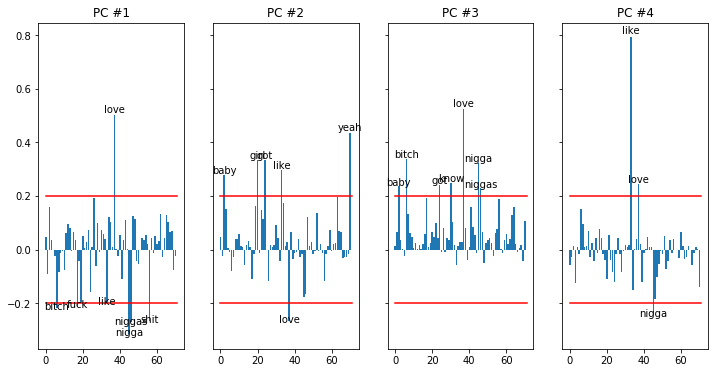

In [39]:
pcs = range(4)
thresholds = [0.2]*len(pcs)

fig, axs = plt.subplots(ncols=len(pcs), sharey=True, figsize=(12,6))

for ax, n_pc, thresh in zip(axs, pcs, thresholds):    
    # Features making up the PC
    mask_feats = (pca.components_[n_pc,:] < -thresh) + (pca.components_[n_pc,:] > thresh)
    feats = list(term_counts.columns[mask_feats])
    vals = (np.arange(pca.n_features_)[mask_feats], pca.components_[n_pc, mask_feats])

    # Plot the PC weights
    ax.bar(range(pca.n_features_), pca.components_[n_pc,:])
    ax.plot([0, pca.n_features_],  thresh*np.array([1,1]), 'r-')
    ax.plot([0, pca.n_features_], -thresh*np.array([1,1]), 'r-')
    ax.set_title("PC #{}".format(n_pc+1))
    for feat, x, y in zip(feats, vals[0],vals[1]):
        ax.annotate(feat,xy=(x,y*1.02), horizontalalignment='center')    
        
plt.show()

In [ ]:
from sklearn.preprocessing import normalize

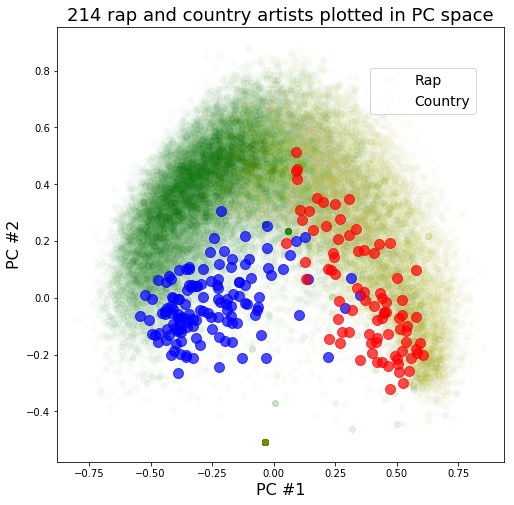

In [80]:
# Perform PCA
pca = PCA(n_components=10)
pca.fit(term_counts)
X = pca.transform(term_counts)
X_songs = pca.transform(song_term_counts)

X = normalize(X, norm='l1')
X_songs = normalize(X_songs)

# Plot artists (or songs) in PC space
# mask_a = [song['genre'] == 'rap' for songs in all_songs]
# mask_b = [song['genre'] == 'country' for song in all_songs]
mask_a = [artist['genre'] == 'rap' for artist in artists]
mask_b = [artist['genre'] == 'country' for artist in artists]
# mask_a = [artist['gender'] == 'male' for artist in artists]
# mask_b = [artist['gender'] == 'female' for artist in artists]

fig, ax = plt.subplots(figsize=(8,8))
pcs = [1,2]
num_song = np.arange(30000)
ma = [song['genre'] == 'rap' for song in all_songs]
mb = [song['genre'] == 'country' for song in all_songs]
ax.plot(X_songs[ma, pcs[0]-1], X_songs[ma, pcs[1]-1], 'go', alpha=0.02, markersize=4)
ax.plot(X_songs[mb, pcs[0]-1], X_songs[mb, pcs[1]-1], 'yo', alpha=0.02, markersize=4)

ax.plot(X[mask_a, pcs[0]-1], X[mask_a, pcs[1]-1], 'bo', alpha=0.6, markersize=10)
ax.plot(X[mask_b, pcs[0]-1], X[mask_b, pcs[1]-1], 'ro', alpha=0.6, markersize=10)

# Plot a single song in the artist PC space

ax.set_title("{} rap and country artists plotted in PC space".format(X.shape[0]), fontsize=fs+2)
ax.set_xlabel("PC #{}".format(pcs[0]), fontsize=fs)
ax.set_ylabel("PC #{}".format(pcs[1]), fontsize=fs)
ax.legend(["Rap","Country"], loc=(0.7,0.8), fontsize=fs-2)
plt.show()

https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction
Very interesting! I see a similar sort of wavy pattern when I perform PCA on all the songs, as is shown in the example on the Wikipedia page of how PCA is not good when the intrinsic high-dimensional variables vary in a non-linear manner.

#### For the blog post:
  - Start with a linear technique (PCA) and show how the data don't separate well
  - Then use a nonlinear dimensionality reduction and (hopefully) be able to show that the data separate, indicating the intrinsic variables are nonlinear

#### Manifold learning
http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [63]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold

In [78]:
X.shape

(12375, 80)

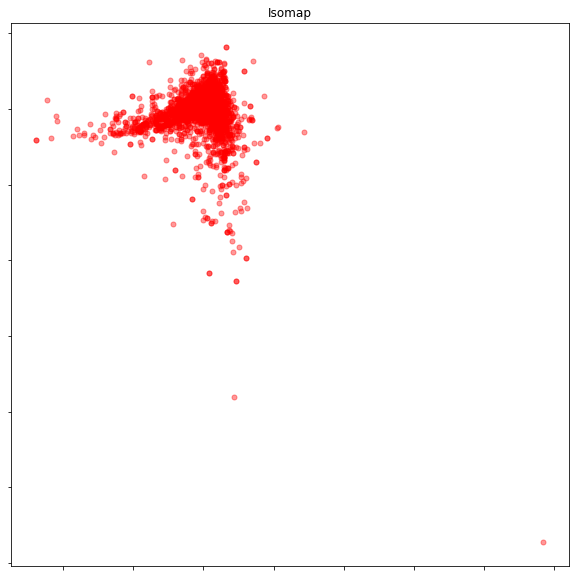

In [111]:
# from mpl_toolkits.mplot3d import Axes3D
n_neighbors = 10
n_components = 2
X = term_counts.as_matrix()
X = X[np.random.randint(0,len(X), (5000)),:]
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Y[:, 0], Y[:, 1], 'ro', markersize=5, alpha=0.4)
ax.set_title("Isomap")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())